<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/dots/dots_Silhouette_test_DINOV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


🔄 Processing: resize_224


Extracting embeddings: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]



🔄 Processing: pad_center_224


Extracting embeddings: 100%|██████████| 12/12 [00:01<00:00, 10.44it/s]



🔄 Processing: resize_50_pad


Extracting embeddings: 100%|██████████| 12/12 [00:01<00:00, 10.59it/s]



🔄 Processing: resize_100_pad


Extracting embeddings: 100%|██████████| 12/12 [00:01<00:00, 10.60it/s]



🔄 Processing: resize_150_pad


Extracting embeddings: 100%|██████████| 12/12 [00:01<00:00, 10.28it/s]



🔄 Processing: resize_200_pad


Extracting embeddings: 100%|██████████| 12/12 [00:01<00:00, 10.26it/s]



🔄 Processing: grid_2x2


Extracting embeddings: 100%|██████████| 12/12 [00:01<00:00, 10.07it/s]


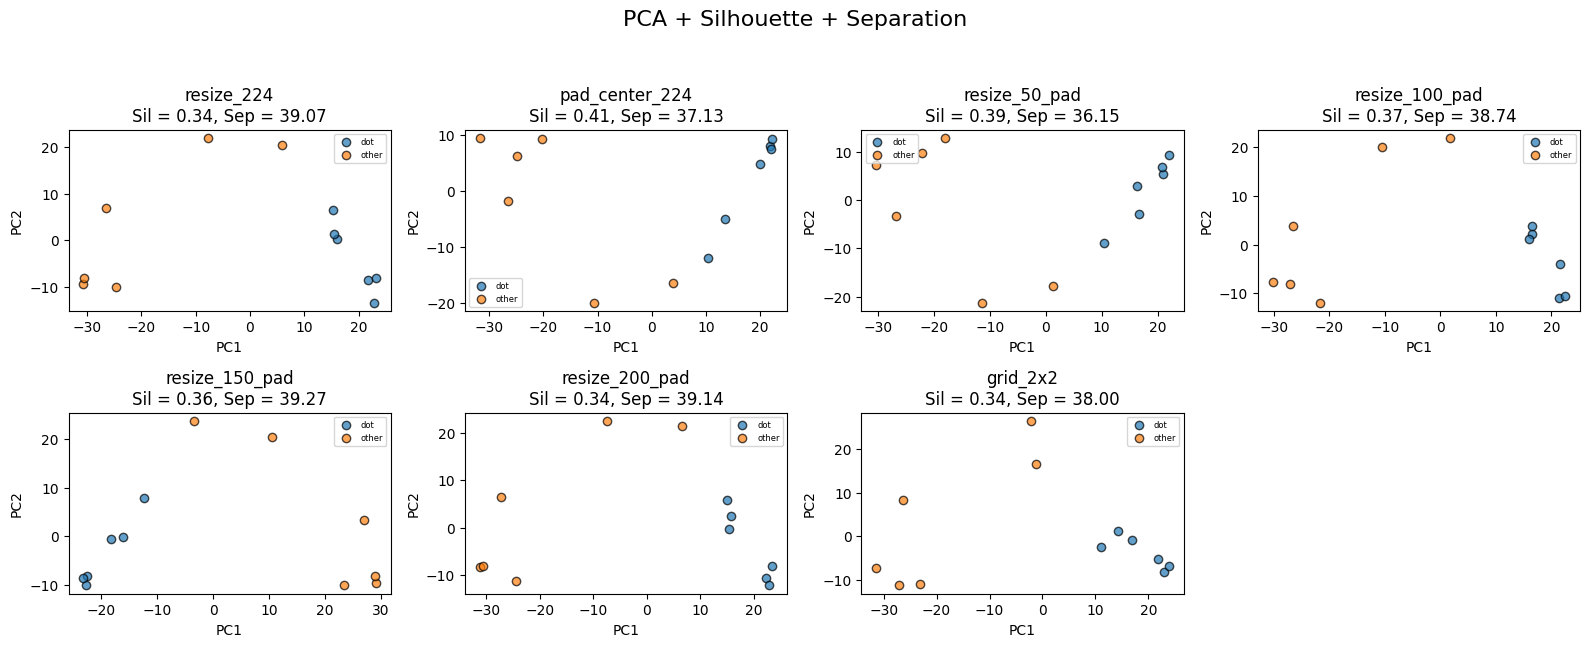


📋 Summary Table:
Transformation  Silhouette Score  Separation Score
pad_center_224             0.409            37.126
 resize_50_pad             0.385            36.150
resize_100_pad             0.374            38.738
resize_150_pad             0.356            39.270
    resize_224             0.342            39.071
resize_200_pad             0.341            39.141
      grid_2x2             0.335            38.001


In [ ]:
# 📦 ייבוא ספריות
import os
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import timm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd

# 📁 נתיבים
base_dir = "/content/drive/MyDrive/dots_data_new"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# 🧠 טעינת מודל DINOv2 גדול מ־timm
dinov2_model = timm.create_model('vit_base_patch14_dinov2', pretrained=True, num_classes=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dinov2_model.to(device).eval()

# טרנספורמציה בסיסית שמתאימה למודל
data_config = timm.data.resolve_model_data_config(dinov2_model)
default_transform = timm.data.create_transform(**data_config, is_training=False)

# === פונקציות טרנספורמציה שונות ===
from torchvision import transforms as T

class PadToCenter224:
    def __call__(self, img):
        w, h = img.size
        scale = min(224 / w, 224 / h, 1.0)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.BICUBIC)
        canvas = Image.new("RGB", (224, 224), (0, 0, 0))
        left = (224 - new_w) // 2
        top = (224 - new_h) // 2
        canvas.paste(img, (left, top))
        return default_transform(canvas)

def resize_and_pad(size):
    class ResizeAndPad:
        def __call__(self, img):
            img = img.resize((size, size), Image.BICUBIC)
            canvas = Image.new("RGB", (224, 224), (0, 0, 0))
            left = (224 - size) // 2
            top = (224 - size) // 2
            canvas.paste(img, (left, top))
            return default_transform(canvas)
    return ResizeAndPad()

class Duplicate2x2Grid:
    def __call__(self, img):
        w, h = img.size
        grid_img = Image.new("RGB", (w * 2, h * 2))
        for i in range(2):
            for j in range(2):
                grid_img.paste(img, (i * w, j * h))
        grid_img = grid_img.resize((224, 224), Image.BICUBIC)
        return default_transform(grid_img)

transforms_dict = {
    "resize_224": default_transform,
    "pad_center_224": PadToCenter224(),
    "resize_50_pad": resize_and_pad(50),
    "resize_100_pad": resize_and_pad(100),
    "resize_150_pad": resize_and_pad(150),
    "resize_200_pad": resize_and_pad(200),
    "grid_2x2": Duplicate2x2Grid(),
}

# === פונקציות עזר ===

def get_image_paths(directory):
    image_paths = []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img))
    return image_paths

def extract_embeddings_with_transform(image_paths, transform):
    embeddings, labels = [], []
    with torch.no_grad():
        for path in tqdm(image_paths, desc="Extracting embeddings"):
            img = Image.open(path).convert("RGB")
            tensor_img = transform(img).unsqueeze(0).to(device)
            feats = dinov2_model.forward_features(tensor_img)
            pooled = dinov2_model.forward_head(feats, pre_logits=True)
            embeddings.append(pooled.squeeze().cpu().numpy())
            labels.append(os.path.basename(os.path.dirname(path)))
    return np.array(embeddings), np.array(labels)

def compute_class_separation(X, y):
    classes = np.unique(y)
    centroids = [np.mean(X[y == cls], axis=0) for cls in classes]
    dists = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            d = np.linalg.norm(centroids[i] - centroids[j])
            dists.append(d)
    return np.mean(dists)

# === הרצת ניסויים ===

train_images = get_image_paths(train_dir)
silhouette_scores, separation_scores, all_embeddings = {}, {}, {}

n_plots = len(transforms_dict)
rows, cols = 3, 4
plt.figure(figsize=(cols * 4, rows * 3))

for i, (name, transform) in enumerate(transforms_dict.items(), 1):
    print(f"\n🔄 Processing: {name}")
    X, y = extract_embeddings_with_transform(train_images, transform)
    all_embeddings[name] = {"X": X, "y": y}

    sil_score = silhouette_score(X, y)
    sep_score = compute_class_separation(X, y)

    silhouette_scores[name] = sil_score
    separation_scores[name] = sep_score

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    classes = np.unique(y)
    class_to_color = {cls: plt.cm.tab10(i % 10) for i, cls in enumerate(classes)}

    plt.subplot(rows, cols, i)
    for cls in classes:
        idx = y == cls
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                    label=cls, color=class_to_color[cls],
                    alpha=0.7, edgecolors='k')
    plt.title(f"{name}\nSil = {sil_score:.2f}, Sep = {sep_score:.2f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(fontsize=6)

plt.suptitle("PCA + Silhouette + Separation", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === טבלת סיכום ===
summary_df = pd.DataFrame({
    "Transformation": list(silhouette_scores.keys()),
    "Silhouette Score": list(silhouette_scores.values()),
    "Separation Score": list(separation_scores.values())
})
summary_df = summary_df.sort_values(by="Silhouette Score", ascending=False)

print("\n📋 Summary Table:")
print(summary_df.to_string(index=False, float_format="%.3f"))



Evaluating transformation: resize_224


Extracting embeddings: 100%|██████████| 118/118 [00:15<00:00,  7.69it/s]



📊 Classification Report:
              precision    recall  f1-score   support

         dot      1.000     0.982     0.991       111
       other      0.778     1.000     0.875         7

    accuracy                          0.983       118
   macro avg      0.889     0.991     0.933       118
weighted avg      0.987     0.983     0.984       118



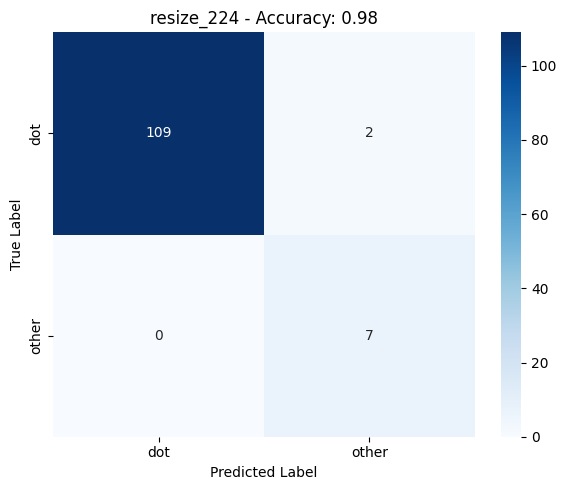


Evaluating transformation: pad_center_224


Extracting embeddings: 100%|██████████| 118/118 [00:11<00:00, 10.12it/s]



📊 Classification Report:
              precision    recall  f1-score   support

         dot      1.000     0.964     0.982       111
       other      0.636     1.000     0.778         7

    accuracy                          0.966       118
   macro avg      0.818     0.982     0.880       118
weighted avg      0.978     0.966     0.970       118



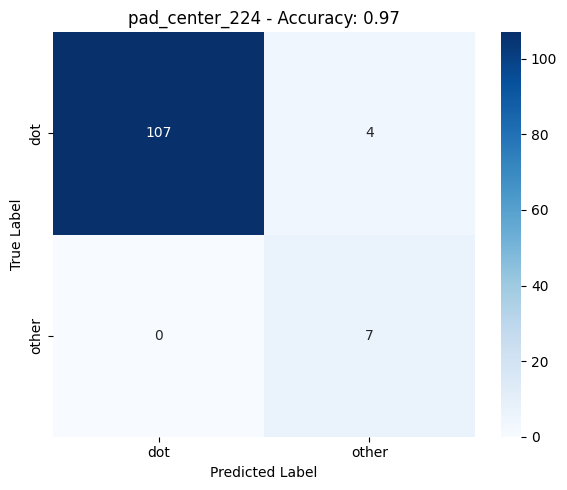


Evaluating transformation: resize_50_pad


Extracting embeddings: 100%|██████████| 118/118 [00:11<00:00, 10.03it/s]



📊 Classification Report:
              precision    recall  f1-score   support

         dot      1.000     0.973     0.986       111
       other      0.700     1.000     0.824         7

    accuracy                          0.975       118
   macro avg      0.850     0.986     0.905       118
weighted avg      0.982     0.975     0.977       118



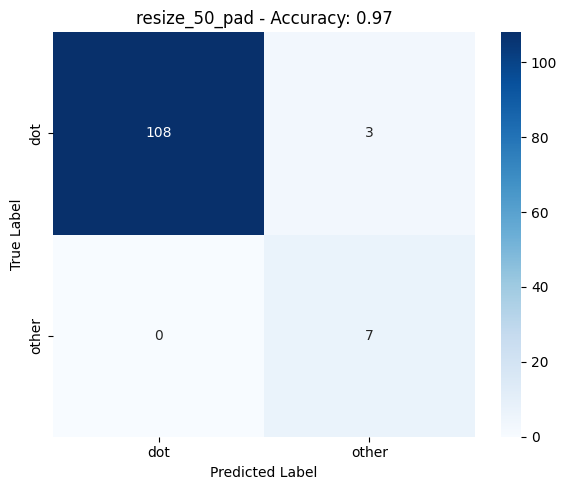


Evaluating transformation: resize_100_pad


Extracting embeddings: 100%|██████████| 118/118 [00:11<00:00,  9.88it/s]



📊 Classification Report:
              precision    recall  f1-score   support

         dot      1.000     0.973     0.986       111
       other      0.700     1.000     0.824         7

    accuracy                          0.975       118
   macro avg      0.850     0.986     0.905       118
weighted avg      0.982     0.975     0.977       118



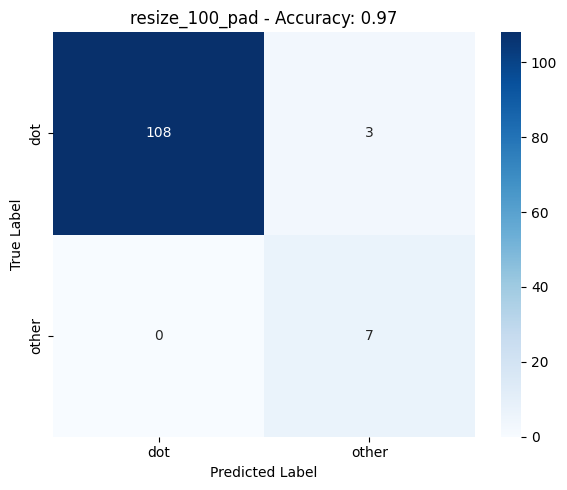


Evaluating transformation: resize_150_pad


Extracting embeddings: 100%|██████████| 118/118 [00:13<00:00,  9.05it/s]



📊 Classification Report:
              precision    recall  f1-score   support

         dot      1.000     0.991     0.995       111
       other      0.875     1.000     0.933         7

    accuracy                          0.992       118
   macro avg      0.938     0.995     0.964       118
weighted avg      0.993     0.992     0.992       118



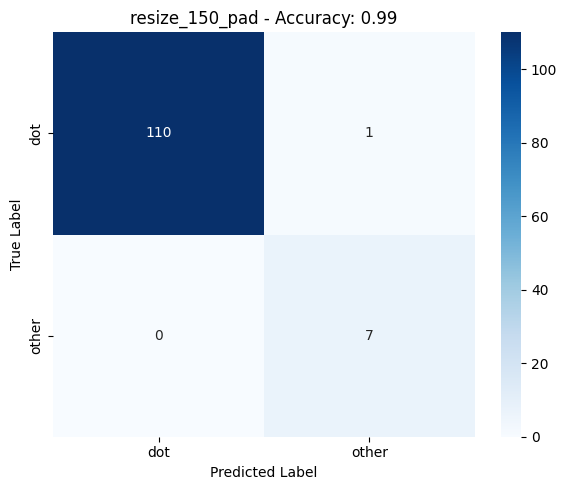


Evaluating transformation: resize_200_pad


Extracting embeddings: 100%|██████████| 118/118 [00:12<00:00,  9.68it/s]



📊 Classification Report:
              precision    recall  f1-score   support

         dot      1.000     0.982     0.991       111
       other      0.778     1.000     0.875         7

    accuracy                          0.983       118
   macro avg      0.889     0.991     0.933       118
weighted avg      0.987     0.983     0.984       118



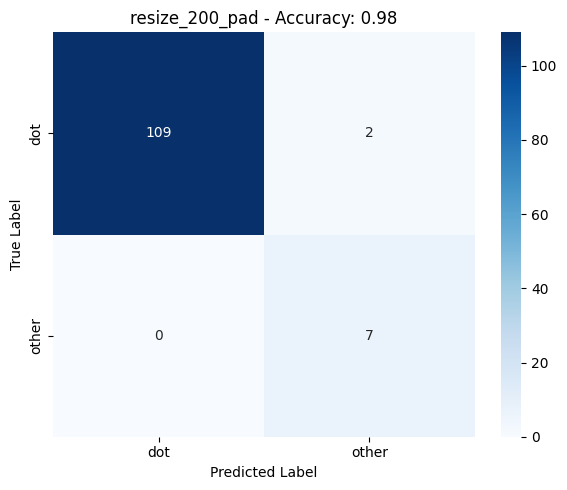


Evaluating transformation: grid_2x2


Extracting embeddings: 100%|██████████| 118/118 [00:12<00:00,  9.76it/s]



📊 Classification Report:
              precision    recall  f1-score   support

         dot      1.000     0.973     0.986       111
       other      0.700     1.000     0.824         7

    accuracy                          0.975       118
   macro avg      0.850     0.986     0.905       118
weighted avg      0.982     0.975     0.977       118



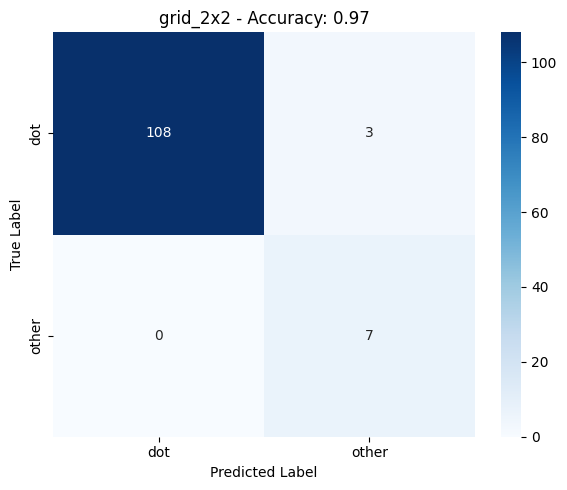

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder

test_dir = os.path.join(base_dir, "test")
test_images = get_image_paths(test_dir)

results = {}

for name, transform in transforms_dict.items():
    print(f"\nEvaluating transformation: {name}")

    # Load train and test embeddings
    X_train, y_train = all_embeddings[name]["X"], all_embeddings[name]["y"]
    X_test, y_test = extract_embeddings_with_transform(test_images, transform)

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Train Logistic Regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train_encoded)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_encoded, y_pred)
    cm = confusion_matrix(y_test_encoded, y_pred)

    # === Classification report ===
    report = classification_report(
        y_test_encoded, y_pred, target_names=le.classes_, digits=3
    )
    print("\n📊 Classification Report:")
    print(report)

    results[name] = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "labels": le.classes_,
        "report": report
    }

    # === Plot Confusion Matrix ===
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Accuracy: {acc:.2f}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

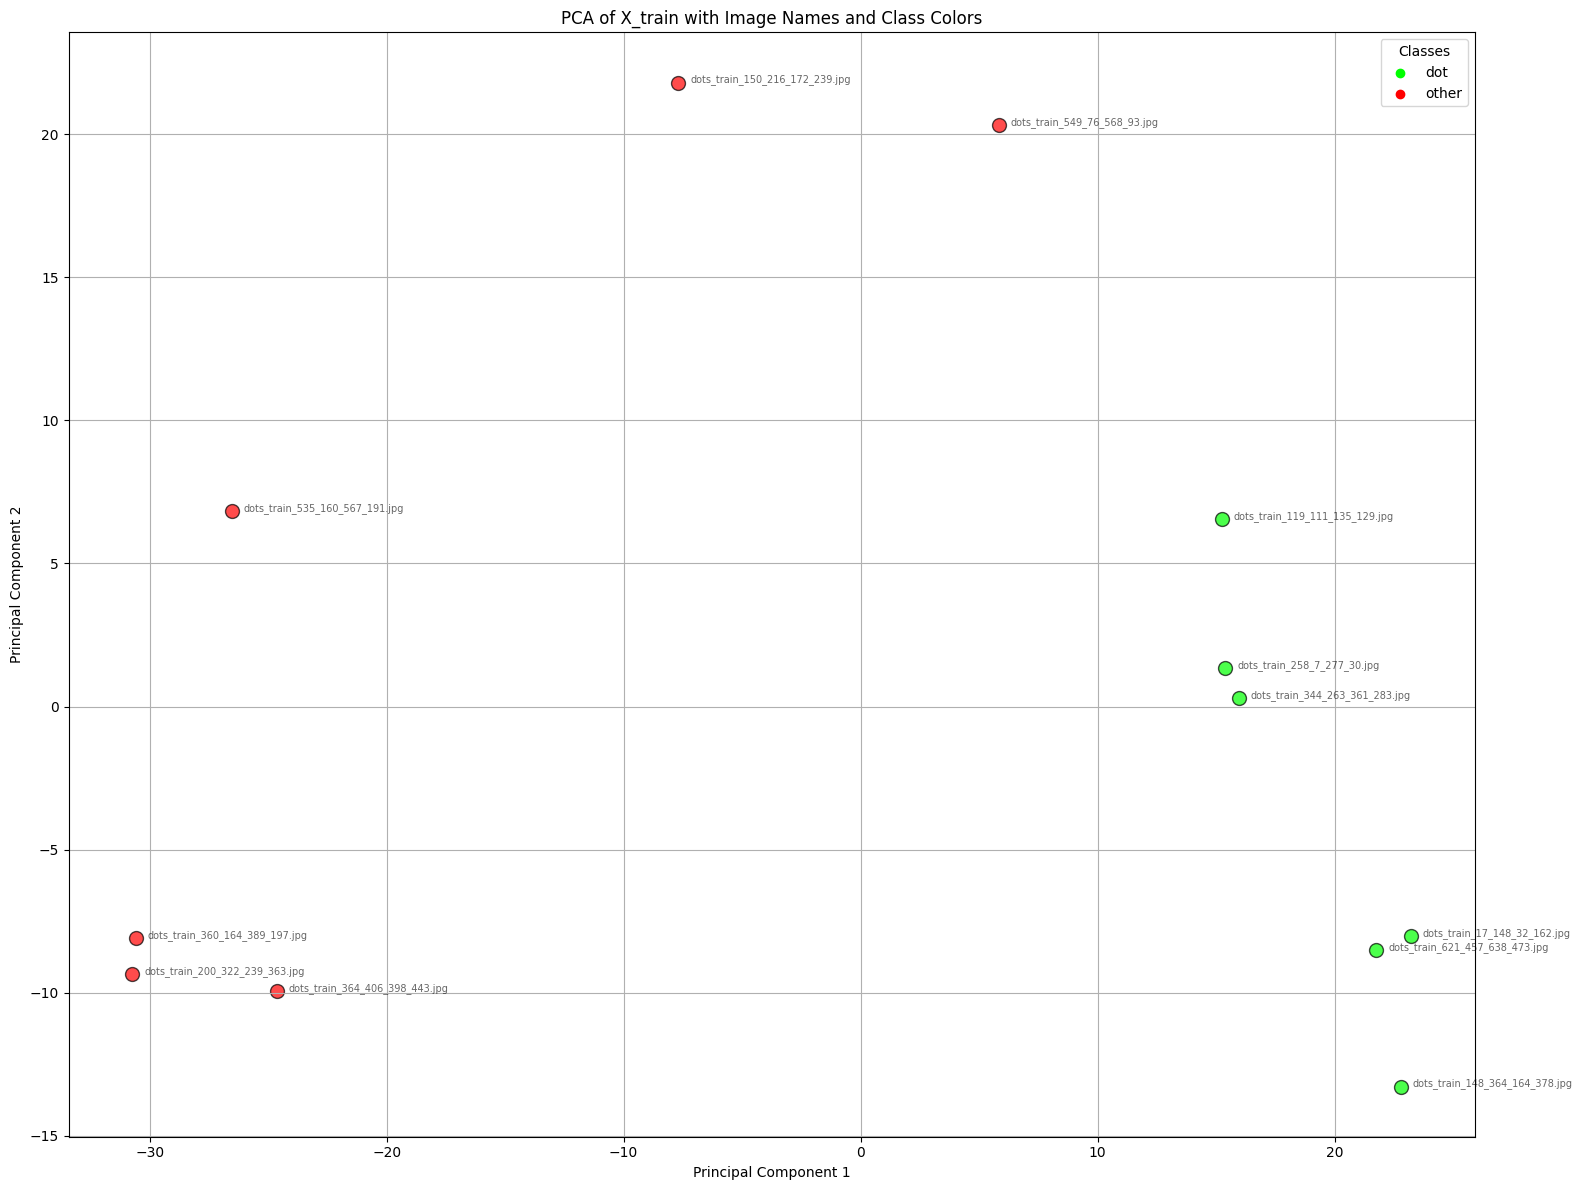

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os

# קבלת נתונים מהאמבדינגס שנשמרו
X = all_embeddings["resize_224"]["X"]
y = all_embeddings["resize_224"]["y"]
image_paths = train_images  # זה משתנה קיים בריצה הראשית שלך

# שמות הקבצים בלבד
image_names = [os.path.basename(path) for path in image_paths]

# המרת תוויות לקטגוריות מספריות
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# פלטת צבעים RGB
color_palette_rgb = [
    (0, 1, 0),      # Green
    (1, 0, 0),      # Blue
    (0, 0, 1),      # Red
    (1, 1, 0),      # Cyan
    (0, 1, 1),      # Yellow
    (1, 0, 1),      # Magenta
    (0.5, 0, 0),    # Dark Blue
    (0, 0.5, 0),    # Dark Green
    (0, 0, 0.5),    # Dark Red
    (0.5, 0.5, 0),  # Teal
]
num_classes = len(np.unique(y_encoded))
colors = [color_palette_rgb[i % len(color_palette_rgb)] for i in y_encoded]

# ציור PCA עם שמות תמונות
plt.figure(figsize=(16, 12))
for i in range(len(X_pca)):
    x, y_ = X_pca[i]
    plt.scatter(x, y_, color=colors[i], s=100, edgecolors='k', alpha=0.7)
    plt.text(x + 0.5, y_, image_names[i], fontsize=7, alpha=0.6)

# הוספת מקרא מחלקות
for class_index in range(num_classes):
    plt.scatter([], [], color=color_palette_rgb[class_index % len(color_palette_rgb)],
                label=le.inverse_transform([class_index])[0])

# הגדרות גרף
plt.legend(title="Classes")
plt.title("PCA of X_train with Image Names and Class Colors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
